# Plot example data for a single patient

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
%matplotlib inline

In [3]:
# Config
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

In [4]:
# Connect to MIMIC
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)
# cur.close()
# con.close()

In [5]:
# Load admissions
query = """
SELECT ad.subject_id
  , ad.hadm_id
  , ad.admission_type
  , ad.diagnosis
  , ic.icustay_id
  , ic.first_careunit
  , ic.last_careunit
  , ic.intime as icu_intime
  , ad.hospital_expire_flag
  , pa.expire_flag
FROM admissions ad
INNER JOIN icustays ic
ON ad.subject_id = ic.subject_id
INNER JOIN patients pa
ON ad.subject_id = pa.subject_id
WHERE ad.subject_id = 40080
"""

admissions = pd.read_sql_query(query,con)

In [6]:
# First few rows of admissions
admissions.head()

,subject_id,hadm_id,admission_type,diagnosis,icustay_id,first_careunit,last_careunit,icu_intime,hospital_expire_flag,expire_flag
0,40080,162107,EMERGENCY,CONGESTIVE HEART FAILURE,252522,MICU,MICU,2106-05-31 16:43:46,0,1


In [7]:
# Load chartevents
query = """
SELECT ce.icustay_id
  , ce.charttime
  , ce.charttime - ie.intime AS icutime
  , di.label
  , ce.value
  , ce.valuenum
  , ce.valueuom
FROM chartevents ce
INNER join d_items di
ON ce.itemid = di.itemid
INNER join icustays ie
ON ce.icustay_id = ie.icustay_id
WHERE ce.icustay_id = 252522
AND error != 1
ORDER BY ce.charttime
"""

charts = pd.read_sql_query(query,con)

In [8]:
# First few rows of charts
charts.head()

,icustay_id,charttime,icutime,label,value,valuenum,valueuom
0,252522,2106-05-31 17:16:00,00:32:14,Non Invasive Blood Pressure systolic,104,104,mmHg
1,252522,2106-05-31 17:16:00,00:32:14,Heart Rate,90,90,bpm
2,252522,2106-05-31 17:16:00,00:32:14,Respiratory Rate,28,28,insp/min
3,252522,2106-05-31 17:16:00,00:32:14,Non Invasive Blood Pressure mean,74,74,mmHg
4,252522,2106-05-31 17:16:00,00:32:14,Non Invasive Blood Pressure diastolic,63,63,mmHg


In [9]:
# Load outputevents
query = """
SELECT oe.icustay_id
  , oe.charttime
  , oe.charttime - ie.intime AS icutime
  , di.label
  , oe.value
  , oe.valueuom
FROM outputevents oe 
INNER JOIN icustays ie
  ON oe.icustay_id = ie.icustay_id
INNER JOIN d_items di
  ON oe.itemid = di.itemid
WHERE oe.subject_id = 40080
ORDER BY oe.charttime
"""

outputs = pd.read_sql_query(query,con)

In [10]:
# First few rows of outputs
outputs.head()

,icustay_id,charttime,icutime,label,value,valueuom
0,252522,2106-05-31 17:29:00,00:45:14,Pre-Admission,60,mL
1,252522,2106-05-31 20:18:00,03:34:14,Foley,80,mL
2,252522,2106-05-31 21:00:00,04:16:14,Foley,60,mL
3,252522,2106-05-31 22:00:00,05:16:14,Foley,60,mL
4,252522,2106-05-31 23:00:00,06:16:14,Foley,60,mL


In [11]:
# Load inputevents
query = """
SELECT inp.icustay_id
  , inp.starttime
  , inp.endtime
  , inp.starttime - ie.intime AS icustarttime
  , inp.endtime - ie.intime AS icuendtime
  , di.label
  , inp.amount
  , inp.amountuom
  , inp.rate
  , inp.rateuom
FROM inputevents_mv inp 
INNER join icustays ie
  ON inp.icustay_id = ie.icustay_id
INNER join d_items di
  ON inp.itemid = di.itemid
WHERE inp.subject_id = 40080
AND lower(inp.statusdescription) != 'rewritten'
ORDER BY inp.starttime
"""

inputs = pd.read_sql_query(query,con)

In [12]:
# First few rows of inputs
inputs.head()

,icustay_id,starttime,endtime,icustarttime,icuendtime,label,amount,amountuom,rate,rateuom
0,252522,2106-05-31 17:29:00,2106-05-31 21:59:00,00:45:14,05:15:14,NaCl 0.9%,45.000001,mL,10,mL/hour
1,252522,2106-05-31 19:30:00,2106-06-01 03:00:00,02:46:14,10:16:14,Furosemide (Lasix),0.037500,mg,5,mg/hour
2,252522,2106-05-31 19:30:00,2106-06-01 03:00:00,02:46:14,10:16:14,NaCl 0.9%,37.500001,mL,5,mL/hour
3,252522,2106-05-31 20:00:00,2106-05-31 20:01:00,03:16:14,03:17:14,Gastric Meds,30.000000,mL,NaN,
4,252522,2106-05-31 20:00:00,2106-05-31 20:01:00,03:16:14,03:17:14,Lansoprazole (Prevacid),1.000000,dose,NaN,


In [13]:
# Load labevents
query = """
SELECT le.subject_id
  , ie.icustay_id
  , le.charttime
  , le.charttime - ie.intime AS icutime
  , di.label
  , le.value
  , le.valuenum
  , le.valueuom
FROM labevents le
INNER join icustays ie
  ON le.subject_id = ie.subject_id
  AND le.charttime >= ie.intime
  AND le.charttime <= ie.outtime
INNER JOIN d_labitems di
  ON le.itemid = di.itemid
WHERE le.subject_id = 40080
ORDER BY le.charttime
"""

labs = pd.read_sql_query(query,con)

In [14]:
# First few rows of labs
labs.head()

,subject_id,icustay_id,charttime,icutime,label,value,valuenum,valueuom
0,40080,252522,2106-05-31 21:21:00,04:37:14,SODIUM,156,156.0,mEq/L
1,40080,252522,2106-05-31 21:21:00,04:37:14,POTASSIUM,3.5,3.5,mEq/L
2,40080,252522,2106-05-31 21:21:00,04:37:14,CHLORIDE,116,116.0,mEq/L
3,40080,252522,2106-06-01 03:38:00,10:54:14,BICARBONATE,33,33.0,mEq/L
4,40080,252522,2106-06-01 03:38:00,10:54:14,ANION GAP,12,12.0,mEq/L


In [101]:
# Snip data to first 24 hours
charts = charts.loc[charts.icutime.dt.days==0]
outputs = outputs.loc[outputs.icutime.dt.days==0]
inputs = inputs.loc[inputs.icustarttime.dt.days==0]
labs = labs.loc[labs.icutime.dt.days==0]

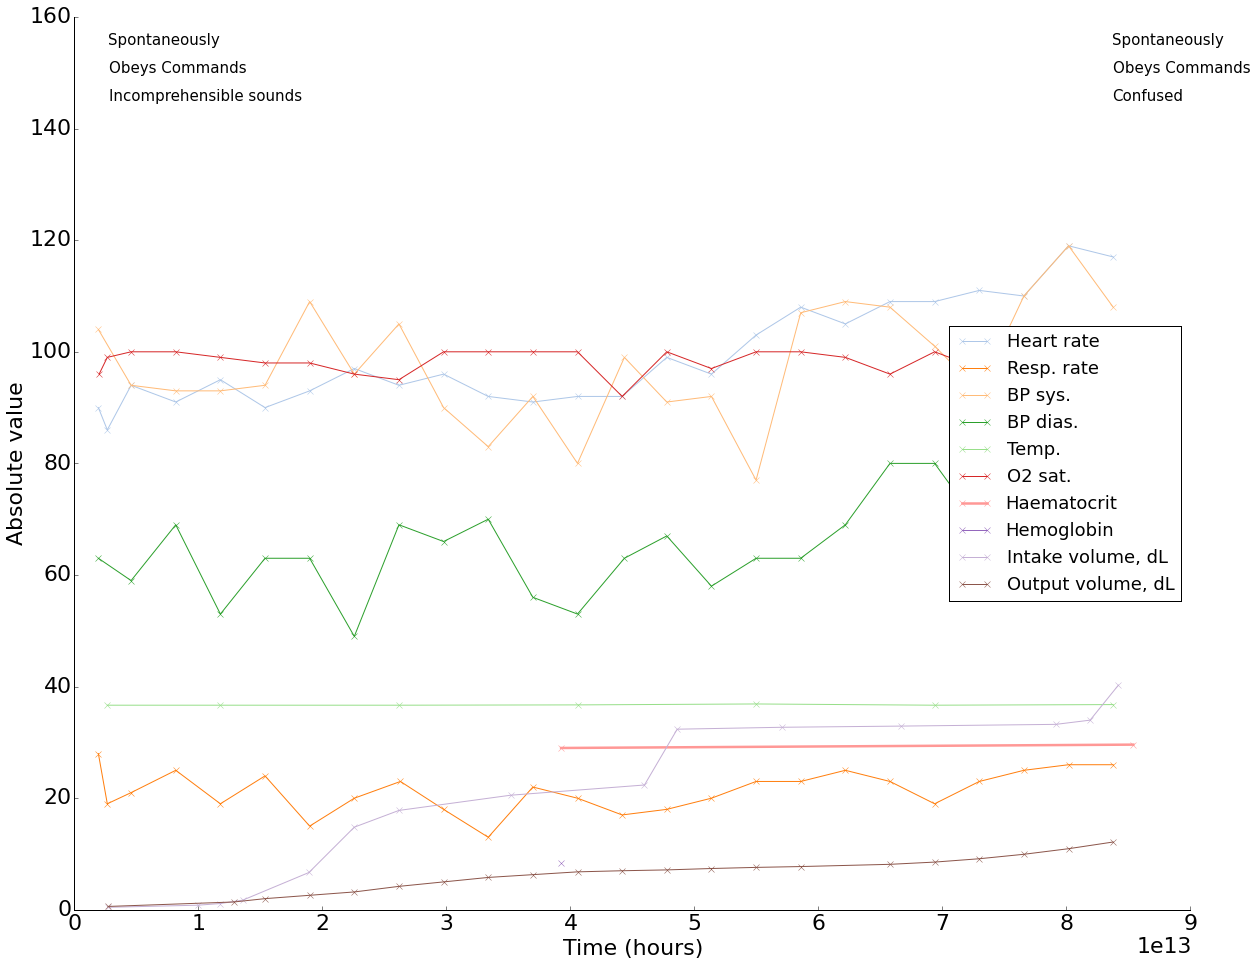

In [105]:
# Plot sample data over first 24 hours from admission to ICU
# Credit: Randal Olson for styling advice (http://www.randalolson.com/2014/06/28/)

# Prepare the size of the figure
fig = plt.figure(figsize=(20, 16))
plt.rcParams.update({'font.size': 22})

# "Tableau 20" colors as RGB.   
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)
    
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(True)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(True)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    

# Limit the range of the plot to only where the data is.       
plt.ylim(0,160) 

# Plot a few vital signs
plt.plot(charts.icutime[charts.label=='Heart Rate'], 
         charts.valuenum[charts.label=='Heart Rate'],
         color=tableau20[1], marker='x', markersize=6, label='Heart rate')

plt.plot(charts.icutime[charts.label=='Respiratory Rate'], 
         charts.valuenum[charts.label=='Respiratory Rate'],
         color=tableau20[2], marker='x', markersize=6, label='Resp. rate')

# plt.plot(charts.icutime[charts.label=='Non Invasive Blood Pressure mean'], 
#          charts.valuenum[charts.label=='Non Invasive Blood Pressure mean'],
#          color='red', markersize=6, label='BP mean')

plt.plot(charts.icutime[charts.label=='Non Invasive Blood Pressure systolic'], 
         charts.valuenum[charts.label=='Non Invasive Blood Pressure systolic'],
         color=tableau20[3], lw=2.5, 
         marker='x', markersize=6, label='BP sys.')

plt.plot(charts.icutime[charts.label=='Non Invasive Blood Pressure diastolic'], 
         charts.valuenum[charts.label=='Non Invasive Blood Pressure diastolic'],
         color=tableau20[4], lw=2.5, 
         marker='x', markersize=6, label='BP dias.')

plt.plot(charts.icutime[charts.label=='Temperature Fahrenheit'], 
         (charts.valuenum[charts.label=='Temperature Fahrenheit']-32)/1.8,
         color=tableau20[5], lw=2.5, 
         marker='x', markersize=6, label='Temp.')

plt.plot(charts.icutime[charts.label=='O2 saturation pulseoxymetry'], 
         charts.valuenum[charts.label=='O2 saturation pulseoxymetry'],
         color=tableau20[6], lw=2.5, 
         marker='x', markersize=6, label='O2 sat.')

# Plot some laboratory values
plt.plot(labs.icutime[labs.label=='HEMATOCRIT'], 
         labs.valuenum[labs.label=='HEMATOCRIT'], 
         color=tableau20[7], lw=2.5, 
         marker='x', markersize=6, label='Haematocrit')

plt.plot(labs.icutime[labs.label=='HEMOGLOBIN'], 
         labs.valuenum[labs.label=='HEMOGLOBIN'], 
         color=tableau20[8], lw=2.5,
         marker='x', markersize=6, label='Hemoglobin')

# Plot some input/output events
plt.plot(inputs.icustarttime[inputs.amountuom=='mL'], 
         inputs.amount[inputs.amountuom=='mL'].cumsum()/100, 
         color=tableau20[9], lw=2.5,
         marker='x', markersize=6, label='Intake volume, dL')

plt.plot(outputs.icutime, 
         outputs.value.cumsum()/100, 
         color=tableau20[10], lw=2.5marker='x', markersize=6, label='Output volume, dL')

# Plot Glasgow Coma Scale measurements every hour or so
# plt.text(-10,155,'GCS - Eye Opening',fontsize=14)
for i, txt in enumerate(charts.value[charts.label=='GCS - Eye Opening'].values):
    if np.mod(i,6)==0 and i < 65:
        plt.annotate(txt, (charts.icutime[charts.label=='GCS - Eye Opening'].values[i],155),fontsize=15)

# plt.text(-60,150,'GCS - Motor Response',fontsize=14)
for i, txt in enumerate(charts.value[charts.label=='GCS - Motor Response'].values):
    if np.mod(i,6)==0 and i < 65:
        plt.annotate(txt, (charts.icutime[charts.label=='GCS - Motor Response'].values[i],150),fontsize=15)

# plt.text(-60,145,'GCS - Verbal Response',fontsize=15)  
for i, txt in enumerate(charts.value[charts.label=='GCS - Verbal Response'].values):
    if np.mod(i,6)==0 and i < 65:
        plt.annotate(txt, (charts.icutime[charts.label=='GCS - Verbal Response'].values[i],145),fontsize=15)

plt.legend(loc=5,fontsize=18)
plt.xlabel('Time (hours)',fontsize=22)
plt.ylabel('Absolute value',fontsize=22)

# Save the figure
# fig.savefig('examplepatient.pdf', bbox_inches='tight')

TypeError: 'int' object has no attribute '__getitem__'